### Audio Load by Barney

In [1]:
from barney_functions import *
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import soundfile as sf
import itertools
from sklearn.metrics import confusion_matrix

# Load Zebra Audio

In [2]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)
y = df['label']

Finding longest file (Better Labels)


100%|█████████████████████████████████████████| 413/413 [00:07<00:00, 55.05it/s]


Loading files


100%|█████████████████████████████████████████| 413/413 [00:07<00:00, 58.47it/s]


In [3]:
y = df['label']

In [4]:
audio_files, y = balancer(audio_files,y)

Initial class proportions:
[0.574 0.034 0.092 0.3  ]
----------------------
Balancing: snort
Multiplier: 1.0
----------------------
Balancing: softsnort
Multiplier: 11.0
----------------------
Balancing: squeal
Multiplier: 3.0
----------------------
Balancing: whinnie
Multiplier: 1.0
----------------------
Final class proportions:
[0.377 0.245 0.181 0.197]


# Load Non Zebra Audio

In [5]:
nzebra_path = 'big bounce small.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)

Padding


100%|███████████████████████████████████████| 448/448 [00:00<00:00, 4887.63it/s]


In [6]:
# Combine zebra and non zebra
all_audio, y_all = add_nzebra(audio_files,y,nzebra_audio,labels_nzebra)

In [7]:
print(all_audio.shape)
print("Unaugmented dataset size: ",all_audio.nbytes/(1e9), 'GB')

(1077, 39923)
Unaugmented dataset size:  0.343976568 GB


In [6]:
#num_classes_all = len(np.unique(y_all))
num_classes = len(np.unique(y))

# Augment Data

In [7]:
augmented_audio = augment_audio_faster_smaller(audio_files)

Augmenting 629 samples


100%|████████████████████████████████████████| 629/629 [00:01<00:00, 375.15it/s]


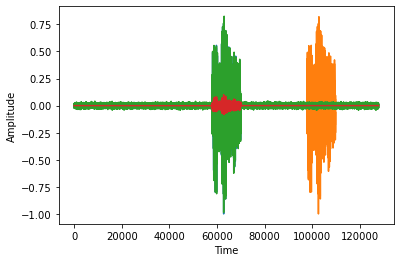

In [8]:
plot_sample(augmented_audio,100)

In [9]:
stfts = calc_stft(augmented_audio)

Augmentation  1


100%|████████████████████████████████████████| 629/629 [00:04<00:00, 146.39it/s]


Augmentation  2


100%|████████████████████████████████████████| 629/629 [00:04<00:00, 145.93it/s]


Augmentation  3


100%|████████████████████████████████████████| 629/629 [00:03<00:00, 158.61it/s]


Augmentation  4


100%|████████████████████████████████████████| 629/629 [00:04<00:00, 135.22it/s]


In [10]:
stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)
print("Augmented dataset size: ",stfts_1D.nbytes/(1e9), 'GB')

100%|█████████████████████████████████████████████| 3/3 [00:17<00:00,  5.76s/it]

Augmented dataset size:  5.1578 GB


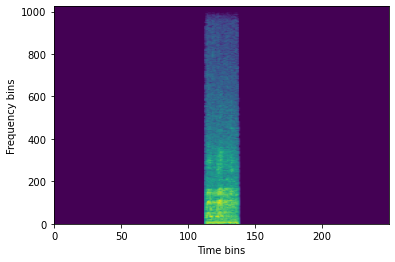

In [11]:
spec_plot(stfts_1D[100,:,:])

# CNN

In [26]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, Adam
from sklearn.model_selection import train_test_split
from optuna.integration import TFKerasPruningCallback
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [27]:
from sklearn.model_selection import KFold

In [28]:
def create_model(num_classes):
    
    model = Sequential()
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=(img_rows, img_cols, 1)))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Dropout(rate=0.40))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])
    return model

# Optimising

In [29]:
import optuna

In [35]:
def objective(trial):
    n_epochs = 2
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
    optimiser = Adam(learning_rate=learning_rate)
    
    filters_1 = trial.suggest_int("filters_1",low=2,high=32,step=6)
    kernel_1 = trial.suggest_int("kernel_size_1",low=8,high=16,step=4)
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    pool_size_1 = 2
    
    filters_2 = trial.suggest_int("filters_2",low=2,high=64,step=6)
    kernel_2 = trial.suggest_int("kernel_size_2",low=6,high=12,step=3)
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    pool_size_2 = 2
    
    dropout_rate = 0.4
    
    lin_1_n = trial.suggest_int("lin_1_n",low=4,high=128,step=1)
    
    batch_size = 128
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])
    
    monitor = "val_categorical_accuracy"
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
        TFKerasPruningCallback(trial, monitor)]
    
    fitted = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       verbose=1,
                       validation_data=(X_test, y_test),
                       callbacks=callbacks)
    
    score = fitted.history[monitor][-1]
    
    return score

In [36]:
train_images, val_images, train_labels, val_labels = train_test_split(stfts[0], y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, img_rows, img_cols = format_for_CNN(train_images, val_images, train_labels, val_labels)
check_class_complete_gen(train_labels, val_labels,y)

OK


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2022-06-06 13:56:46,247] A new study created in memory with name: no-name-8b22e05a-7f5f-447b-9219-51edcf7e5d62
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [2, 64] and step=6, but the range is not divisible by `step`. It will be replaced by [2, 62].
  warnings.warn(
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "filters_1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 32, 'step': 6}
  warnings.warn(


Epoch 1/2
4/4 [==============================] - 124s 31s/step - loss: 1.7566 - categorical_accuracy: 0.1928 - val_loss: 1.6552 - val_categorical_accuracy: 0.1508
Epoch 2/2
4/4 [==============================] - 124s 31s/step - loss: 1.6259 - categorical_accuracy: 0.2306 - val_loss: 1.5608 - val_categorical_accuracy: 0.1825


[I 2022-06-06 14:00:54,499] Trial 0 finished with value: 0.1825396865606308 and parameters: {'learning_rate': 0.0018689612982885062, 'filters_1': 14, 'kernel_size_1': 8, 'kernel_size_2': 9, 'lin_1_n': 88}. Best is trial 0 with value: 0.1825396865606308.
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [2, 64] and step=6, but the range is not divisible by `step`. It will be replaced by [2, 62].
  warnings.warn(
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "filters_1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 32, 'step': 6}

Epoch 1/2
4/4 [==============================] - 84s 21s/step - loss: 1.5066 - categorical_accuracy: 0.3439 - val_loss: 1.2908 - val_categorical_accuracy: 0.4127
Epoch 2/2
4/4 [==============================] - 81s 20s/step - loss: 1.5202 - categorical_accuracy: 0.3519 - val_loss: 1.2789 - val_categorical_accuracy: 0.4365


[I 2022-06-06 14:03:39,570] Trial 1 finished with value: 0.4365079402923584 and parameters: {'learning_rate': 0.0001192088098394699, 'filters_1': 2, 'kernel_size_1': 8, 'kernel_size_2': 12, 'lin_1_n': 97}. Best is trial 1 with value: 0.4365079402923584.
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [2, 64] and step=6, but the range is not divisible by `step`. It will be replaced by [2, 62].
  warnings.warn(
/Users/barnabyemmens/opt/anaconda3/envs/appml/lib/python3.8/site-packages/optuna/trial/_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "filters_1"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 2, 'high': 32, 'step': 6}

Epoch 1/2
1/4 [======>.......................] - ETA: 4:12 - loss: 1.5392 - categorical_accuracy: 0.2891

In [ ]:
optimised_params = study.best_params
print(optimised_params)

In [ ]:
def opt_model(optimised_params):
    n_epochs = 2
    # Conv 1
    filters_1 = 32
    kernel_size_1 = optimised_params['kernel_size_1']
    strides_1 = 1
    padding_1 = 'same'
    activation_1 = 'relu'
    input_shape = (img_rows, img_cols, 1)
    # Pool 1
    pool_size_1 = 2
    # Conv 2
    filters_2 = 64
    kernel_size_2 = optimised_params['kernel_size_2']
    strides_2 = 1
    padding_2 = 'same'
    activation_2 = 'relu'
    # Pool 2
    pool_size_2 = 2
    # Droput
    dropout_rate = 0.4
    # Lin 1
    lin_1_n = optimised_params['lin_1_n']
    
    model = Sequential()
    model.add(Conv2D(filters=filters_1,
                     kernel_size=kernel_size_1,
                     strides=strides_1,
                     padding=padding_1,
                     activation=activation_1,
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=pool_size_1, strides=None))
    model.add(Conv2D(filters=filters_2,
                     kernel_size=kernel_size_2,
                     strides=strides_2,
                     padding=padding_2,
                     activation=activation_2))
    model.add(MaxPooling2D(pool_size=pool_size_2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=lin_1_n, activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    
    model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])
    
    return model

# Folding

In [ ]:
n_folds = 2
n_epochs = 2
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_loss = np.zeros((n_folds,n_epochs))
X = stfts[0]
y = y 
check_class_complete(kfold,X,y)

In [ ]:
fold_no = 1
for train_index, test_index in kfold.split(X, y):
    
    print("-----------------------------------")
    print("FOLD "+str(fold_no))
    print("-----------------------------------")
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train,X_test,y_train,y_test, img_rows, img_cols = format_for_CNN(X_train,X_test,y_train,y_test)
    
    model = opt_model(optimised_params)

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=n_epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
    
    fold_loss[fold_no-1] = history.history['val_categorical_accuracy']
    fold_no += 1

In [ ]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [ ]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

### Inference

In [ ]:
predicted_prob = model.predict(X)
predictions = np.argmax(predicted_prob, axis=1)

In [ ]:
print(predictions.shape)
print(y.shape)

In [ ]:
labels_list = np.unique(y)
onehot_v = pd.get_dummies(y)
onehot_y = onehot_v.to_numpy()
truths = np.argmax(onehot_y, axis=1)
cm = confusion_matrix(truths, predictions, labels=range(num_classes))
print(cm)
plot_confusion_matrix(cm,labels_list)